In [1]:
# import standard python library
import pyodbc
import pandas as pd
import numpy as np
import joblib
from pandasql import sqldf
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

# import PDM library
from ut_connection_lib import Connection, Query
from feature_derivator import engine_pc2000_feature_derivator
from pmm_tools_function import *
from pmm_transformers_library import \
    VHMSReplaceSensorErrorValue, DeriveFeatures, DfMapMinMaxScaler, DfStandardScaler, FeaturesSelector, \
    RemoveByThreshold, InverseTransfromStandardScaller, HealthScoreModelRouter, PapOilImputation, PapOilDataCleanser,\
    EnsureDataTypes

# import scikit learn modules
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.options.mode.chained_assignment = None  # default='warn'

## Get Data From Database

prod_connection = Connection(dbname="PROD")
dev_connection = Connection(dbname="DEVELOPMENT")

unit_population_history_query = Query(source_file="sql_query/sql_query_unit_population_history.txt") 
unit_population_latest_query = Query(source_file="sql_query/sql_query_unit_population_latest.txt") 
vhms_trend_pc2000_query = Query(source_file="sql_query/sql_query_vhms_trend_pc2000.txt") 
vhms_fault_pc2000_query = Query(source_file="sql_query/sql_query_vhms_fault_pc2000.txt") 
pap_oil_query = Query(source_file="sql_query/sql_query_pap_oil.txt")

unit_population_latest = unit_population_latest_query.execute(prod_connection)
vhms_trend_pc2000 = vhms_trend_pc2000_query.execute(prod_connection)
vhms_fault_pc2000 = vhms_fault_pc2000_query.execute(prod_connection)

vhms_trend_pc2000.to_excel('local_data/vhms_trend_pc2000.xlsx')
vhms_fault_pc2000.to_excel('local_data/vhms_fault_pc2000.xlsx')

## Get Data From Local File

In [2]:
unit_population_history = pd.read_excel('local_data/unit_population_history.xlsx')
unit_population_latest = pd.read_excel('local_data/unit_population_latest.xlsx')
hist_comp_repl = pd.read_excel('local_data/historical_component_replacement.xlsx')
vhms_trend_pc2000 = pd.read_excel('local_data/vhms_trend_pc2000.xlsx')
vhms_fault_pc2000 = pd.read_excel('local_data/vhms_fault_pc2000.xlsx')
pap_oil = pd.read_excel('local_data/pap_oil.xlsx')

## Check Data Completeness

In [3]:
vhms_completeness = vhms_trend_pc2000[["UNIT_SRL_NUM", "SMR"]]\
    .drop_duplicates().groupby("UNIT_SRL_NUM")["SMR"]\
    .agg(['min', 'max', 'count'])\
    .reset_index()
vhms_completeness['EXPECTED_SMR'] = vhms_completeness['max'] - vhms_completeness['min']
vhms_completeness['ESTIMATED_SMR'] = vhms_completeness['count']*20
vhms_completeness['COMPLETENESS'] = vhms_completeness['ESTIMATED_SMR']/vhms_completeness['EXPECTED_SMR']
vhms_completeness.columns = ['MCHN_SRL_NUM', 'MIN', 'MAX', 'COUNT', 'EXPECTED_SMR', 'ESTIMATED_SMR', 'COMPLETENESS']


srl_num_passed = vhms_completeness[
    (vhms_completeness['COMPLETENESS']<2) & # ensure no duplication
    (vhms_completeness['COUNT']>=500) & # ensure data size
    (vhms_completeness['COMPLETENESS']>=0.75) # ensure data completeness
]['MCHN_SRL_NUM'].drop_duplicates().tolist()

# Select VHMS that match criteria
vhms_trend_pc2000_selected = vhms_trend_pc2000[
    (vhms_trend_pc2000["UNIT_SRL_NUM"].isin(srl_num_passed)) &
    (vhms_trend_pc2000["COOL_TEMPMAX"]>30) &
    (vhms_trend_pc2000["ENGSPEED_MX"]>0) &
    (vhms_trend_pc2000["ENGOIL_TMPMAX"]>30)
].reset_index(drop=True)
vhms_trend_pc2000_selected['UNIT_SRL_NUM'] = vhms_trend_pc2000_selected['UNIT_SRL_NUM'].astype(str)
vhms_trend_pc2000_selected['UNIT_MODL'] = "PC2000-8"

print("Number of initial units: {}".format(len(vhms_completeness)))
print("Number of passed units: {}".format(len(srl_num_passed)))
print("Number of records: {}".format(len(vhms_trend_pc2000_selected)))

Number of initial units: 234
Number of passed units: 115
Number of records: 165580


# Initialize Preprocessing Pipeline

In [4]:
vhms_params = read_from_file("parameters/engine_pc2000_vhms_params.txt")
vhms_param_name = np.array([s.split(", ")[0] for s in vhms_params])
vhms_param_source = np.array([s.split(", ")[1] for s in vhms_params])
vhms_param_used = np.array([s.split(", ")[2] for s in vhms_params])
primary_features = list(vhms_param_name[np.where(vhms_param_source=='PRIMARY')])
final_features = list(vhms_param_name[np.where(vhms_param_used=='TRUE')])
z_score_anomaly_thres = [(-3,3 )]*len(final_features+primary_features)

# VHMS Healthy Sample

In [5]:
standard_scaler_early_data = DfStandardScaler(final_features+primary_features)
vhms_early_cleaning_pipe = Pipeline([
    ('sensor-error-handling', VHMSReplaceSensorErrorValue(primary_features)),
    ('features-derivator', DeriveFeatures([engine_pc2000_feature_derivator])), 
    ('standard-scaler', standard_scaler_early_data),
    ('anomaly-removal', RemoveByThreshold(primary_features, z_score_anomaly_thres)),
    ('inverse-standard-scaller', InverseTransfromStandardScaller(standard_scaler_early_data))
])

## Healthy Sample from Early Vehicle Life

In [6]:
vhms_pc2000_early_vehicle = vhms_trend_pc2000_selected[(vhms_trend_pc2000_selected['SMR']<1500) & 
                                             (vhms_trend_pc2000_selected['SMR']>500)]
vhms_pc2000_early_vehicle['TIMESTAMP'] = vhms_pc2000_early_vehicle['TIMESTAMP'].map(lambda x: str(x)[:19])
vhms_pc2000_early_vehicle['failure'] = 0

## Healthy Sample ftom Early Component Live

In [7]:
engine_replacement = hist_comp_repl[
    (hist_comp_repl['MODL_UNIT']=='PC2000-8') &
    (hist_comp_repl['COMPONENT']=='ENGINE ASSY') & 
    (hist_comp_repl['LIFETIME_HOUR']>=18000)][['SRL_NUM', 'BEG_HM']]
engine_replacement.columns = ['UNIT_SRL_NUM', 'BEGIN_SMR']
vhms_pc2000_early_component = pd.merge(
    vhms_trend_pc2000_selected, engine_replacement, how='inner', on='UNIT_SRL_NUM')
vhms_pc2000_early_component['RESET_SMR'] = \
    vhms_pc2000_early_component['SMR'] - vhms_pc2000_early_component['BEGIN_SMR']
vhms_pc2000_early_component = vhms_pc2000_early_component[
    (vhms_pc2000_early_component['RESET_SMR']>=500) & 
    (vhms_pc2000_early_component['RESET_SMR']<=1500)].\
    drop(['BEGIN_SMR', 'RESET_SMR'], 1)
vhms_pc2000_early_component['TIMESTAMP'] = vhms_pc2000_early_component['TIMESTAMP'].map(lambda x: str(x)[:19])
vhms_pc2000_early_component['failure'] = 0

## Concat both healthy sample

In [8]:
vhms_pc2000_early = reduce_by_key(
    pd.concat([vhms_pc2000_early_vehicle, vhms_pc2000_early_component]),
    group_key = ['UNIT_SRL_NUM', 'TIMESTAMP'],
    sort_key = ['failure'])
print(len(vhms_pc2000_early_vehicle))
print(len(vhms_pc2000_early_component))
print(len(vhms_pc2000_early))

4872
848
5370


In [9]:
vhms_pc2000_early_transformed = vhms_early_cleaning_pipe.fit_transform(vhms_pc2000_early.copy())

2019-09-10 10:09:52: Fitting sensor error scaler with data
	2019-09-10 10:09:52: Separate sensor value from mean calculation
	2019-09-10 10:09:52: Computing average value of each equipment
	2019-09-10 10:09:52: Computing average value of all equipment
	2019-09-10 10:09:52: Finish fitting scaler
2019-09-10 10:09:52: Transforming data
	2019-09-10 10:09:52: Replacing error value with average for each serial number


### Some data is discarded due to abnormality in early lifetime

In [10]:
unit_discarded = vhms_pc2000_early[
    ~vhms_pc2000_early['UNIT_SRL_NUM'].isin(vhms_pc2000_early_transformed['UNIT_SRL_NUM'].tolist())
]['UNIT_SRL_NUM'].drop_duplicates().tolist()

discarded_units = unit_population_latest[
    unit_population_latest['SRL_NUM'].isin(unit_discarded)].sort_values('SRL_NUM').reset_index(drop=True)
discarded_units

,SRL_NUM,MODL_NUM,ROOM,PLNT,SORT_FLD,CUSTOMER_NAME,CONTRACT,LAST_UPDATED_DATE


# Discovering Degradation Label

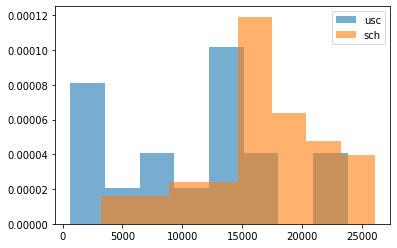

In [11]:
sch_replacement = hist_comp_repl[(hist_comp_repl['MODL_UNIT']=='PC2000-8') &  
                                 (hist_comp_repl['COMPONENT']=='ENGINE ASSY') & 
                                 (hist_comp_repl['STATUS']=='SCH')]

usc_replacement = hist_comp_repl[(hist_comp_repl['MODL_UNIT']=='PC2000-8') &  
                                 (hist_comp_repl['COMPONENT']=='ENGINE ASSY') & 
                                 (hist_comp_repl['STATUS']=='USC')]

plt.hist(usc_replacement['LIFETIME_HOUR'], alpha=0.6, bins=8, label='usc', density=True)
plt.hist(sch_replacement['LIFETIME_HOUR'], alpha=0.6, bins=8, label='sch', density=True)
plt.legend()
plt.show()

In [12]:
# VHMS failure from component replacement (late SMR)

sch_replacement = hist_comp_repl[(hist_comp_repl['MODL_UNIT']=='PC2000-8') &  
                                 (hist_comp_repl['COMPONENT']=='ENGINE ASSY') & 
                                 (hist_comp_repl['LIFETIME_HOUR']>=20000) &
                                 (hist_comp_repl['STATUS']=='SCH')][['SRL_NUM', 'STATUS', 'END_HM', 'LIFETIME_HOUR']]
sch_replacement['RUN_TO_FAILURE'] = sch_replacement['LIFETIME_HOUR'].apply(lambda x: 0.01*x if x<=25000 else 0.01*25000)

usc_replacement = hist_comp_repl[(hist_comp_repl['MODL_UNIT']=='PC2000-8') &  
                                 (hist_comp_repl['COMPONENT']=='ENGINE ASSY') & 
                                 (hist_comp_repl['STATUS']=='USC')][['SRL_NUM', 'STATUS', 'END_HM', 'LIFETIME_HOUR']]
usc_replacement['RUN_TO_FAILURE'] = 200

engine_replacement = pd.concat([usc_replacement])
engine_replacement.columns = ['UNIT_SRL_NUM', 'STATUS', 'END_HM', 'LIFETIME', 'RUN_TO_FAILURE']

vhms_from_replacement = pd.merge(engine_replacement, vhms_trend_pc2000_selected, how='inner', on='UNIT_SRL_NUM')
vhms_from_replacement = \
    vhms_from_replacement[
        (vhms_from_replacement['SMR'] > vhms_from_replacement['END_HM']-vhms_from_replacement['RUN_TO_FAILURE']) & 
        (vhms_from_replacement['SMR'] <= vhms_from_replacement['END_HM'])][vhms_trend_pc2000.columns]
vhms_from_replacement['UNIT_MODL'] = 'HD785-7'

In [13]:
engine_replacement[engine_replacement['UNIT_SRL_NUM']=="20149"]

,UNIT_SRL_NUM,STATUS,END_HM,LIFETIME,RUN_TO_FAILURE


In [14]:
def label_vhms_from_fault(vhms_trend, vhms_fault, fault_code, minimum_duration):
    vhms_fault_specific = vhms_fault[(vhms_fault['CODE']==fault_code) & 
                                   (vhms_fault['TOTAL_DURATION_MINUTES'] >= minimum_duration)].copy()
    vhms_fault_specific['NUM_DAYS'] = \
        (vhms_fault_specific['TO_DATE'].astype('datetime64[ns]') - \
             vhms_fault_specific['FROM_DATE'].astype('datetime64[ns]'))/np.timedelta64(1, 'D')
    vhms_fault_specific.columns = ['UNIT_SRL_NUM'] + vhms_fault_specific.columns.tolist()[1:]
    
    pysql = lambda q: sqldf(q, locals())
    
    query = """
        SELECT 
            trend.*
        FROM vhms_fault_specific fault
        INNER JOIN vhms_trend trend
            ON fault.UNIT_SRL_NUM = trend.UNIT_SRL_NUM AND
               trend.TIMESTAMP >= date(fault.FROM_DATE,'-1 day') AND --fault.FROM_DATE - INTERVAL'2 DAYS'
               trend.TIMESTAMP < fault.TO_DATE
        WHERE fault.TOTAL_DURATION_MINUTES/fault.NUM_DAYS >= {0}
        ORDER BY UNIT_SRL_NUM, TIMESTAMP
    """.format(minimum_duration)
    vhms_from_fault = sqldf(query, locals())
    return vhms_from_fault

In [15]:
vhms_fault_pc2000[vhms_fault_pc2000['CODE']=='B@BAZG'].sort_values('TOTAL_DURATION_MINUTES', ascending=False)

,MCHN_SRL_NUM,CODE,FROM_DATE,TO_DATE,COUNT_EVENT,TOTAL_DURATION_MINUTES
460457,46216,B@BAZG,2015-02-16,2015-02-17,1990,1437.400000
28573,46216,B@BAZG,2015-02-14,2015-02-14,178,1160.200000
335637,46216,B@BAZG,2015-02-15,2015-02-15,3208,1091.483333
478991,46216,B@BAZG,2015-02-19,2015-02-19,59,1049.566667
406855,46216,B@BAZG,2015-02-21,2015-02-22,1445,1039.633333
114608,46216,B@BAZG,2015-02-17,2015-02-17,694,1014.033333
230980,46216,B@BAZG,2015-02-12,2015-02-12,569,905.266667
472741,46216,B@BAZG,2015-02-18,2015-02-19,88,842.250000
217267,20090,B@BAZG,2011-04-23,2011-04-23,15,840.666667
368942,20079,B@BAZG,2011-02-20,2011-02-20,1,717.833333


In [16]:
# VHMS failure from fault code occurence

# Lowering Of Engine Oil Pressure
vhms_from_fault_babazg = label_vhms_from_fault(vhms_trend_pc2000_selected, vhms_fault_pc2000, "B@BAZG", 6000)
# Lowering of engine oil level
vhms_from_fault_babazk =label_vhms_from_fault(vhms_trend_pc2000_selected, vhms_fault_pc2000, "B@BAZK", 6000)
# Engine Overheat
vhms_from_fault_babcns =label_vhms_from_fault(vhms_trend_pc2000_selected, vhms_fault_pc2000, "B@BCNS", 1E6)
# Blowby Pressure High > 20 KPa
vhms_from_fault_fabbzl =label_vhms_from_fault(vhms_trend_pc2000_selected, vhms_fault_pc2000, "F@BBZL", 60)
vhms_from_fault_fabbzl = vhms_from_fault_fabbzl[vhms_from_fault_fabbzl['BLOWBYPRESS_MX']>20]

# Union all
vhms_from_fault = pd.concat([#vhms_from_fault_babazg, vhms_from_fault_babazk, 
                             vhms_from_fault_babcns, vhms_from_fault_fabbzl]).drop_duplicates()

print("Lowering Of Engine Oil Pressure: {}".format(len(vhms_from_fault_babazg)))
print("Lowering of engine oil level: {}".format(len(vhms_from_fault_babazk)))
print("Engine Overheat: {}".format(len(vhms_from_fault_babcns)))
print("Blowby Pressure High > 20 KPa: {}".format(len(vhms_from_fault_fabbzl)))

Lowering Of Engine Oil Pressure: 0
Lowering of engine oil level: 0
Engine Overheat: 0
Blowby Pressure High > 20 KPa: 1635


In [17]:
# VHMS failure from rule abnormality

vhms_from_rule_abnormality = vhms_trend_pc2000_selected[
# high blowby press
    (vhms_trend_pc2000_selected['BLOWBYPRESS_MX']>=30) |
# overheat
    ((vhms_trend_pc2000_selected['COOL_TEMPMAX']>=101) & (vhms_trend_pc2000_selected['ENGOIL_TMPMAX']>=121)) |
# low e_oil press
    ((vhms_trend_pc2000_selected['EOIL_PH_MN']<0.205) & (vhms_trend_pc2000_selected['EOIL_PL_MN']<0.049))
]

In [18]:
len(vhms_from_fault_fabbzl)

1635

In [19]:
vhms_pc2000_early_component[["UNIT_SRL_NUM", "SMR", "ENGSPEED_MX", "ENGSPEED_AV", "BLOWBYPRESS_MX", "BOOST_PRESS_MX",
                            "EOIL_PREMAX", "EOIL_PL_MN", "EOIL_PH_MN", "ENGOIL_TMPMAX", "COOL_TEMPMAX", "FUEL_RATE",
                            "ENG_PWR_AV", "ENG_PWR_MX"
                           ]].sort_values("SMR", ascending=False).reset_index().loc[20]

index                4395
UNIT_SRL_NUM        20149
SMR               30647.6
ENGSPEED_MX          1999
ENGSPEED_AV          1772
BLOWBYPRESS_MX       2.24
BOOST_PRESS_MX        122
EOIL_PREMAX          0.48
EOIL_PL_MN           0.16
EOIL_PH_MN            0.3
ENGOIL_TMPMAX         102
COOL_TEMPMAX           91
FUEL_RATE           120.9
ENG_PWR_AV            438
ENG_PWR_MX            731
Name: 20, dtype: object

In [20]:
vhms_fault_pc2000[(vhms_fault_pc2000['MCHN_SRL_NUM']=="20017") & 
                  (vhms_fault_pc2000["CODE"]=="B@BCNS")
                 ].sort_values("FROM_DATE")

,MCHN_SRL_NUM,CODE,FROM_DATE,TO_DATE,COUNT_EVENT,TOTAL_DURATION_MINUTES
307612,20017,B@BCNS,2008-07-17,2008-07-17,3,5.733333
218378,20017,B@BCNS,2009-07-31,2010-01-10,2,234695.266667
17686,20017,B@BCNS,2010-01-10,2010-01-10,1,0.216667
108089,20017,B@BCNS,2010-01-11,2010-01-11,5,2.266667
13240,20017,B@BCNS,2010-01-12,2010-01-12,3,1.316667
150944,20017,B@BCNS,2011-01-26,2011-01-26,1,0.633333


In [21]:
# Union all failure records
vhms_pc2000_failure = pd.concat([vhms_from_fault, vhms_from_replacement, vhms_from_rule_abnormality], sort=False)
vhms_pc2000_failure = vhms_pc2000_failure[vhms_pc2000_failure["SMR"]>=6000]
vhms_pc2000_failure['TIMESTAMP'] = vhms_pc2000_failure['TIMESTAMP'].map(lambda x: str(x)[:19])
vhms_pc2000_failure = vhms_pc2000_failure.drop_duplicates()

vhms_failure_cleaning_pipe = Pipeline([
    ('sensor-error-handling', VHMSReplaceSensorErrorValue(primary_features)),
    ('features-derivator', DeriveFeatures([engine_pc2000_feature_derivator]))
])

print("failure from fault: {}".format(len(vhms_from_fault)))
print("failure from replacement: {}".format(len(vhms_from_replacement)))
print("failure from rule abnormality: {}".format(len(vhms_from_rule_abnormality)))
print("Total failure sample: {}".format(len(vhms_pc2000_failure)))

vhms_pc2000_failure_transformed = vhms_failure_cleaning_pipe.fit_transform(vhms_pc2000_failure.copy())
vhms_pc2000_failure_transformed['failure'] = 1

failure from fault: 1230
failure from replacement: 146
failure from rule abnormality: 243
Total failure sample: 1257
2019-09-10 10:10:52: Fitting sensor error scaler with data
	2019-09-10 10:10:52: Separate sensor value from mean calculation
	2019-09-10 10:10:52: Computing average value of each equipment
	2019-09-10 10:10:52: Computing average value of all equipment
	2019-09-10 10:10:52: Finish fitting scaler
2019-09-10 10:10:52: Transforming data
	2019-09-10 10:10:52: Replacing error value with average for each serial number


In [22]:
256/(1352+256+243)

0.13830361966504592

# Combine VHMS Failure and Healthy

In [23]:
vhms_dataset = reduce_by_key(
    pd.concat([vhms_pc2000_early_transformed, vhms_pc2000_failure_transformed], sort=False),
    group_key = ['UNIT_SRL_NUM', 'TIMESTAMP'],
    sort_key = ['failure'])
vhms_dataset[primary_features] = vhms_dataset[primary_features].astype(float)
vhms_dataset[final_features] = vhms_dataset[final_features].astype(float)
vhms_dataset['UNIT_SRL_NUM'] = vhms_dataset['UNIT_SRL_NUM'].astype(str)
vhms_dataset['TIMESTAMP'] = vhms_dataset['TIMESTAMP'].astype(str)
vhms_dataset['UNIT_MODEL'] = "HD785-7"
vhms_dataset = vhms_dataset[~vhms_dataset.isnull().any(axis=1)]

vhms_dataset.groupby('failure')['TIMESTAMP'].count()

failure
0    4658
1    1255
Name: TIMESTAMP, dtype: int64

# Add contract and plant details

In [24]:
unit_population_latest_pc2000 = \
    unit_population_latest[unit_population_latest['MODL_NUM']=='PC2000-8'][['SRL_NUM', 'CONTRACT']]
unit_population_latest_pc2000.columns = ['UNIT_SRL_NUM', 'CONTRACT']

vhms_x_info_dataset = pd.merge(
    vhms_dataset, unit_population_latest_pc2000,
    how='inner', on='UNIT_SRL_NUM'
)

In [25]:
vhms_x_info_dataset.groupby(['CONTRACT', 'failure'])['UNIT_SRL_NUM'].count()

CONTRACT  failure
FMC       0          1221
          1           432
NON-FMC   0          3437
          1           823
Name: UNIT_SRL_NUM, dtype: int64

In [26]:
unit_population_latest_pc2000.drop_duplicates().groupby('CONTRACT')['UNIT_SRL_NUM'].count()

CONTRACT
FMC         27
NON-FMC    332
Name: UNIT_SRL_NUM, dtype: int64

# Add PAP To Dataset

In [27]:
pap_features = ['TBN', 'IRON', 'COPPER', 'ALUMINIUM', 'CHROMIUM', 'OXIDATION', 'LEAD', 
                'DIR_TRANS', 'SOX', 'WATER', 'GLYCOL', 'DILUTION', 'NICKEL', 'TIN', 'VISC_40', 
                'VISC_CST', 'CALCIUM', 'MAGNESIUM', 'ZINC', 'SILICON', 'POTASSIUM', 'SODIUM']

In [28]:
pap_cleaning_pipe = Pipeline([
    ('pap-data-cleaner', PapOilDataCleanser(unit_model='PC2000-8', component='ENGINE', features=pap_features)),
    ('pap-imputer', PapOilImputation(unit_model='PC2000-8', component='ENGINE', features=pap_features))
]).fit(pap_oil.copy())

2019-09-10 10:10:53: Fitting Oil Analyisis data for references


In [29]:
pap_engine_pc2000 = pap_cleaning_pipe.transform(pap_oil.copy())

In [30]:
vhms_x_pap_dataset = join_vhms_with_pap(vhms_x_info_dataset, pap_engine_pc2000, time_window=30)
vhms_x_pap_dataset['has_pap'] = vhms_x_pap_dataset['LAB_NUM'].map(lambda x: 1 if x is not None and x==x else 0)
vhms_x_pap_dataset = vhms_x_pap_dataset[vhms_x_pap_dataset['has_pap']==1]

# Descriptive VHMS

In [31]:
vhms_trend_pc2000_selected.columns

Index(['UNIT_SRL_NUM', 'SMR', 'TIMESTAMP', 'ENGSPEED_MX', 'ENGSPEED_AV',
       'BLOWBYPRESS_MX', 'LBF_EXHTEMPMAX', 'LBR_EXHTEMPMAX', 'RBF_EXHTEMPMAX',
       'RBR_EXHTEMPMAX', 'BOOST_PRESS_MX', 'EOIL_PREMAX', 'EOIL_PL_MN',
       'EOIL_PH_MN', 'ENGOIL_TMPMAX', 'COOL_TEMPMAX', 'COOL_TEMPMIN',
       'FUEL_RATE', 'AMBIENT_TEMPMAX', 'AMBIENT_TEMPAVE', 'AMBIENT_TEMPMIN',
       'ATOMOS_PRESAVE', 'PUMP_1F_PMAX', 'PUMP_1R_PMAX', 'PUMP_2F_PMAX',
       'PUMP_2R_PMAX', 'FANPUMPF_PMAX', 'FANPUMPR_PMAX', 'HYDOILTEMPMAX',
       'HYDOILTEMPAVE', 'HYDOILTEMPMIN', 'PTO_TEMP_MX', 'PTO_TEMP_MN',
       'PUMP_1_TORQUE_MX', 'PUMP_1_TORQUE_AV', 'PUMP_2_TORQUE_MX',
       'PUMP_2_TORQUE_AV', 'FANPUMPTORQUE_MX', 'FANPUMPTORQUE_AV',
       'ENG_PWR_MX', 'ENG_PWR_AV', 'ECO_MODE_ON', 'UNIT_MODL'],
      dtype='object')

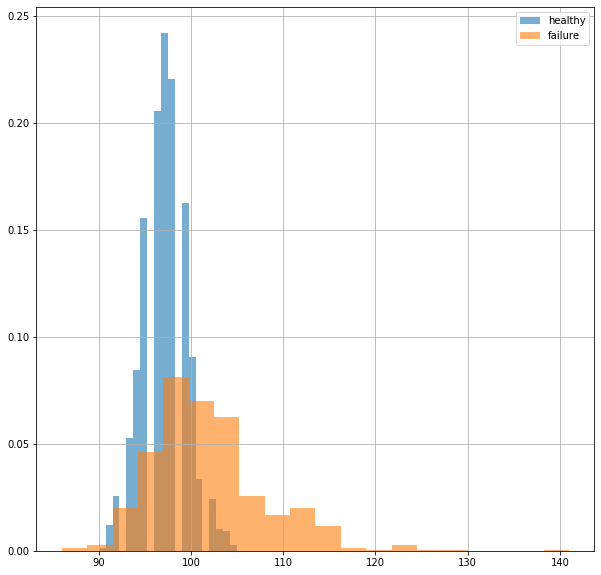

In [32]:
# distribution check
param = "ENGOIL_TMPMAX"
val_1 = (vhms_pc2000_early_transformed[param])
val_2 = (vhms_pc2000_failure_transformed[param])
plt.figure(figsize=(10,10))
plt.hist(val_1, density=True, bins=20, alpha=0.6, label='healthy')
plt.hist(val_2, density=True, bins=20, alpha=0.6, label='failure')
plt.legend()
plt.grid()
plt.show()

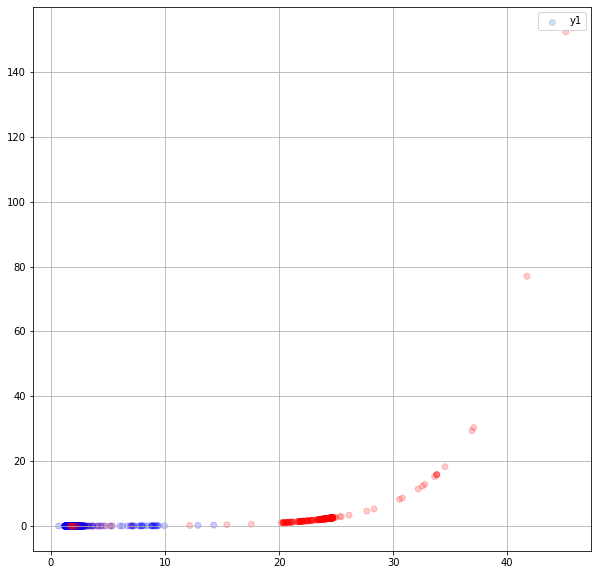

In [33]:
x = vhms_x_pap_dataset["BLOWBYPRESS_MX"]
# y = vhms_pc2000_failure_transformed["BLOWBY_PRESS_MX_LOG"]
y1 =  np.exp((x-20)/5)
plt.figure(figsize=(10,10))
plt.grid()
plt.scatter(x,y1, label='y1', c=vhms_x_pap_dataset['failure'], cmap='bwr', alpha=0.2)
plt.legend()

# Train Classifier Model

In [34]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import LogisticRegression as Logit
# from sklearn.ensemble import GradientBoostingClassifier as GBC
# from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [35]:
def train_classifier_model(model, X, y, test_size, random_state=42, proba=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if proba:
        health_score = model.predict_proba(X_test)[:,0]
    else:
        health_score = model.predict(X_test)
    result = pd.DataFrame({
        "y_true": y_test, 
        "health_score": health_score,
        "y_pred": y_pred
    })
    print(model)
    
    try:
        pd.DataFrame({"features":list(X.columns), "importances":model.feature_importances_})\
            .sort_values('importances')\
            .plot.barh(x='features', y='importances')
        plt.grid()
        plt.show()
    except:
        pass

    return result

def analyze_model_performance(result):
    hs_result_summary = result.groupby('y_true')['health_score'].agg(
    ['count','min', percentile(10), percentile(25), 'mean', 'median', percentile(75), percentile(90), 'max', 'std'])

    cm = confusion_matrix(result["y_true"], result["y_pred"])
    plot_confusion_matrix(cm, classes=['healthy', 'failure'], normalize=True)
    plot_confusion_matrix(cm, classes=['healthy', 'failure'], normalize=False)
    plt.show()

    false_positive = cm[1,0]/(cm[1,0]+cm[1,1])
    false_negative = cm[0,1]/(cm[0,1]+cm[0,0])
    hs_acc = (hs_result_summary.loc[0]['median']*hs_result_summary.loc[0]['count'] + 
              (1-hs_result_summary.loc[1]['median'])*hs_result_summary.loc[1]['count'])/\
              hs_result_summary['count'].sum()

    print("False Positive: {}".format(false_positive))
    print("False Negative: {}".format(false_negative))
    print("Accuracy: {}".format(hs_acc))
    print("Result summary: ")
    print(hs_result_summary)

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

## Build Model With PAP

We only get few records that have PAP match. So we will try to build two models, without adn with PAP and compare both results. This section is for the second approach

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


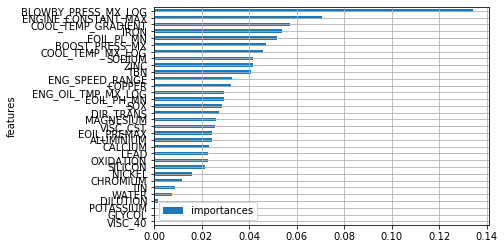

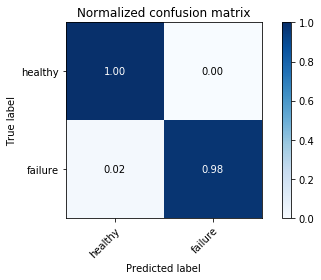

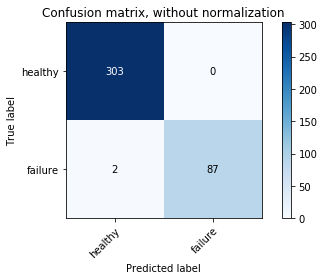

False Positive: 0.02247191011235955
False Negative: 0.0
Accuracy: 0.9465752494033745
Result summary: 
        count       min  percentile_10  percentile_25      mean    median  \
y_true                                                                      
0         303  0.655055       0.879674       0.931785  0.950881  0.970307   
1          89  0.007714       0.046231       0.075207  0.176657  0.134218   

        percentile_75  percentile_90       max       std  
y_true                                                    
0            0.989742       0.996010  1.000000  0.053247  
1            0.265440       0.367711  0.597374  0.132437  


In [36]:
# randomly sample 18% of fmc healthy data
fmc_healthy = vhms_x_pap_dataset[(vhms_x_pap_dataset['failure']==0) & 
                                  (vhms_x_pap_dataset['CONTRACT']=='FMC')].sample(frac=1)

# and randomly sample 4.3% of non-fmc healthy data
nonfmc_healthy = vhms_x_pap_dataset[(vhms_x_pap_dataset['failure']==0) & 
                                     (vhms_x_pap_dataset['CONTRACT']=='NON-FMC')].sample(frac=1)

# combine fmc and non-fmc healthy data with failure data
vhms_x_pap_dataset_resample = pd.concat([fmc_healthy, 
                                   nonfmc_healthy, 
                                   vhms_x_pap_dataset[vhms_x_pap_dataset['failure']==1]
                                  ])

health_score_model_with_pap = RFC(n_estimators=100, min_samples_split=10, max_features=1)
X = vhms_x_pap_dataset_resample[list(final_features)+pap_features]
y = vhms_x_pap_dataset_resample['failure']

with_pap_result = train_classifier_model(health_score_model_with_pap, X, y, test_size=0.33, random_state=42)
analyze_model_performance(with_pap_result)

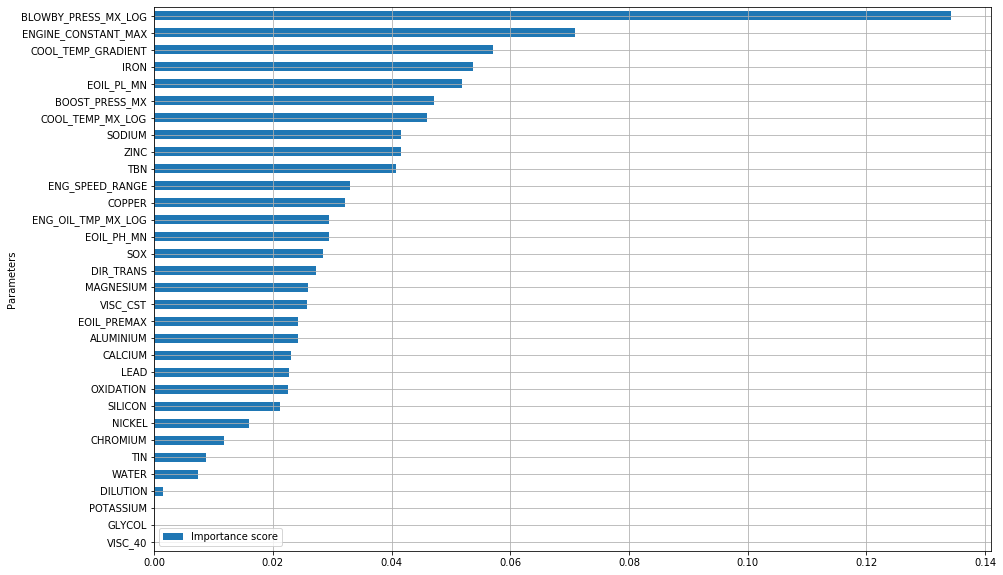

In [37]:
pd.DataFrame({
    "Parameters": list(final_features)+pap_features,
    "Importance score": health_score_model_with_pap.feature_importances_
}).sort_values('Importance score').set_index("Parameters").plot(kind="barh", figsize=(15,10), grid=True)

## Build Model Without PAP

We only get few records that have PAP match. So we will try to build two models, without adn with PAP and compare both results. This section is for the second approach

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 0.1},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


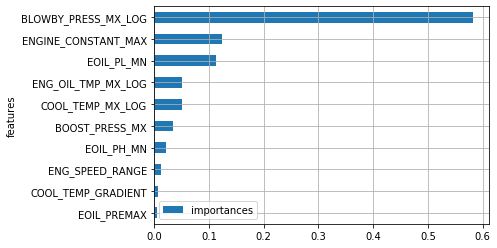

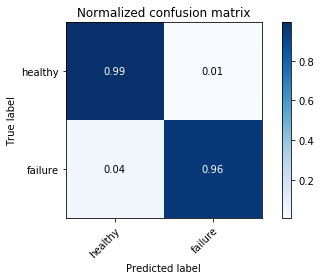

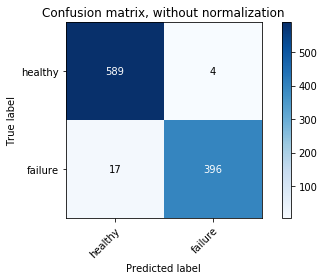

False Positive: 0.04116222760290557
False Negative: 0.006745362563237774
Accuracy: 0.9974341451292247
Result summary: 
        count       min  percentile_10  percentile_25      mean   median  \
y_true                                                                     
0         593  0.252691       0.977306       0.998333  0.985652  1.00000   
1         413  0.000000       0.000000       0.000000  0.046559  0.00625   

        percentile_75  percentile_90       max       std  
y_true                                                    
0            1.000000       1.000000  1.000000  0.064178  
1            0.016026       0.048485  0.986548  0.155877  


In [38]:
# randomly sample 18% of fmc healthy data
# randomly sample 18% of fmc healthy data
fmc_healthy = vhms_x_info_dataset[(vhms_x_info_dataset['failure']==0) & 
                                  (vhms_x_info_dataset['CONTRACT']=='FMC')].sample(frac=0.6)

# and randomly sample 4.3% of non-fmc healthy data
nonfmc_healthy = vhms_x_info_dataset[(vhms_x_info_dataset['failure']==0) & 
                                     (vhms_x_info_dataset['CONTRACT']=='NON-FMC')].sample(frac=0.3)

# combine fmc and non-fmc healthy data with failure data
vhms_dataset_resample = pd.concat([fmc_healthy, 
                                   nonfmc_healthy, 
                                   vhms_x_info_dataset[vhms_x_info_dataset['failure']==1]
                                  ])

health_score_model_without_pap = RFC(n_estimators=100, min_samples_split=10, class_weight={0:1, 1:0.1})
X = vhms_dataset_resample[final_features]
y = vhms_dataset_resample['failure']

without_pap_result = train_classifier_model(health_score_model_without_pap, X, y, test_size=0.333, random_state=42)
analyze_model_performance(without_pap_result)

In [39]:
len(set(vhms_x_pap_dataset_resample['UNIT_SRL_NUM']))

35

In [40]:
len(set(vhms_dataset_resample['UNIT_SRL_NUM']))

113

In [41]:
35/(113+35)

0.23648648648648649

## Accuracy on discarded data (all healthy)

In [42]:
discarded = vhms_dataset.loc[[i for i in vhms_dataset.index if i not in vhms_dataset_resample.index]]
X_discarded = discarded[final_features]
y_discarded = discarded['failure']
y_pred = health_score_model_without_pap.predict(X_discarded)
health_score = health_score_model_without_pap.predict_proba(X_discarded)
print("Accuracy: ", np.sum(y_discarded==y_pred)/len(y_discarded))
print("Average HS: ", np.mean(health_score[:,0]))
print("Median HS: ", np.median(health_score[:,0]))
print("Standard Deviation HS: ", np.std(health_score[:,0]))

Accuracy:  0.9930931491506441
Average HS:  0.8583676799850781
Median HS:  1.0
Standard Deviation HS:  0.33511351846816906


# Scoring Pipeline for Scoring Script

In [43]:
vhms_scoring_cleaning_pipe = Pipeline([
    ('ensure-numeric-datatypes', EnsureDataTypes(['SMR']+primary_features)),
    ('sensor-error-handling', VHMSReplaceSensorErrorValue(primary_features)),
    ('features-derivator', DeriveFeatures([engine_pc2000_feature_derivator]))
]).fit(vhms_trend_pc2000_selected.copy())

pap_scoring_cleaning_pipe = Pipeline([
    ('ensure-numeric-datatypes', EnsureDataTypes(['HRS_KM_TOT', 'HRS_KM_OC']+pap_features)),
    ('pap-data-cleaner', PapOilDataCleanser(unit_model='PC2000-8', component='ENGINE', features=pap_features)),
    ('pap-imputer', PapOilImputation(unit_model='PC2000-8', component='ENGINE', features=pap_features))
]).fit(pap_oil.copy())

model_route = [
    (True, health_score_model_with_pap, final_features+pap_features),
    (False, health_score_model_without_pap, final_features)]

scoring_standard_scaler = DfStandardScaler(final_features+primary_features+pap_features)
health_scoring_pipe = Pipeline([
    ('standard-scaler', scoring_standard_scaler),
    ('inverse-standard-scaller', InverseTransfromStandardScaller(scoring_standard_scaler)),
    ('ensure-numeric-datatypes', EnsureDataTypes(final_features+pap_features)),
    ('model-router', HealthScoreModelRouter(flag_columns='with_pap', routes=model_route))
]).fit(vhms_x_pap_dataset[vhms_x_pap_dataset['failure']==0].copy())

2019-09-10 10:10:58: Fitting sensor error scaler with data
	2019-09-10 10:10:58: Separate sensor value from mean calculation
	2019-09-10 10:10:58: Computing average value of each equipment
	2019-09-10 10:11:00: Computing average value of all equipment
	2019-09-10 10:11:00: Finish fitting scaler
2019-09-10 10:11:00: Transforming data
	2019-09-10 10:11:00: Replacing error value with average for each serial number
2019-09-10 10:11:02: Fitting Oil Analyisis data for references


In [44]:
joblib.dump(vhms_scoring_cleaning_pipe, 'pc2000-8_engine_vhms_prep_pipe.pkl')
joblib.dump(pap_scoring_cleaning_pipe, 'pc2000-8_engine_pap_prep_pipe.pkl')
joblib.dump(health_scoring_pipe, 'pc2000-8_engine_health_scoring_pipe.pkl')

['pc2000-8_engine_health_scoring_pipe.pkl']

# Scoring Script

In [45]:
vhms_completeness.sort_values('COUNT', ascending=False)

,MCHN_SRL_NUM,MIN,MAX,COUNT,EXPECTED_SMR,ESTIMATED_SMR,COMPLETENESS
18,20052,32.1,56499.1,2728,56467.0,54560,0.966228
86,20194,34.0,55499.7,2716,55465.7,54320,0.979344
84,20192,32.8,54999.6,2699,54966.8,53980,0.982047
62,20134,34.4,51025.3,2493,50990.9,49860,0.977822
78,20179,20.4,48134.8,2350,48114.4,47000,0.976839
71,20151,20.1,47472.2,2322,47452.1,46440,0.978671
74,20160,30.9,49382.6,2307,49351.7,46140,0.934922
61,20133,33.1,50907.9,2247,50874.8,44940,0.883345
72,20157,20.1,50087.5,2211,50067.4,44220,0.883209
82,20188,32.2,43865.6,2150,43833.4,43000,0.980987


In [47]:
vhms_pipe = joblib.load('pc2000-8_engine_vhms_prep_pipe.pkl')
pap_pipe = joblib.load('pc2000-8_engine_pap_prep_pipe.pkl')
hs_scoring_pipe = joblib.load('pc2000-8_engine_health_scoring_pipe.pkl')

2019-09-10 10:13:55: Transforming data
	2019-09-10 10:13:55: Replacing error value with average for each serial number
index                                 4140
SRL_NUM                              20194
MODL_NUM                          PC2000-8
ROOM                                EX1746
PLNT                                   JBY
SORT_FLD                               NaN
CUSTOMER_NAME        PAMAPERSADA NUSANTARA
CONTRACT                               FMC
LAST_UPDATED_DATE      2017-11-09 00:00:00
Name: 0, dtype: object
     REP_NUM STATUS  BEG_HM  END_HM  LIFETIME_HOUR
121        1    SCH       0   17577          17577
123        2    SCH   17577   40351          22774


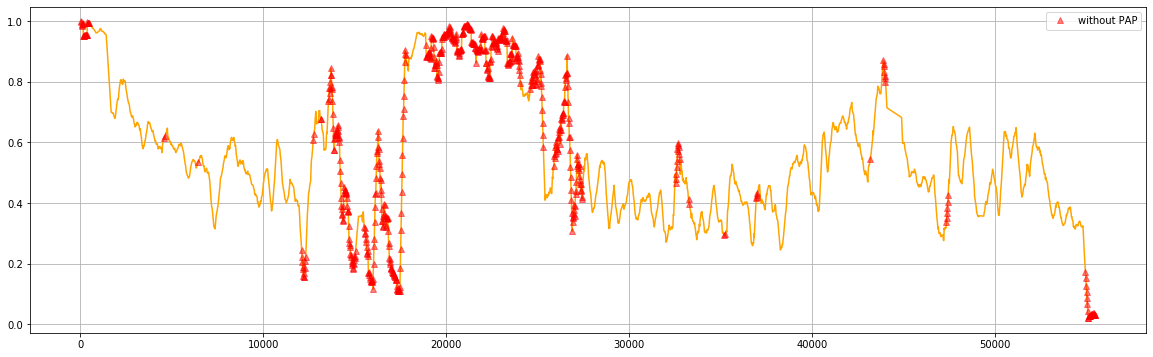

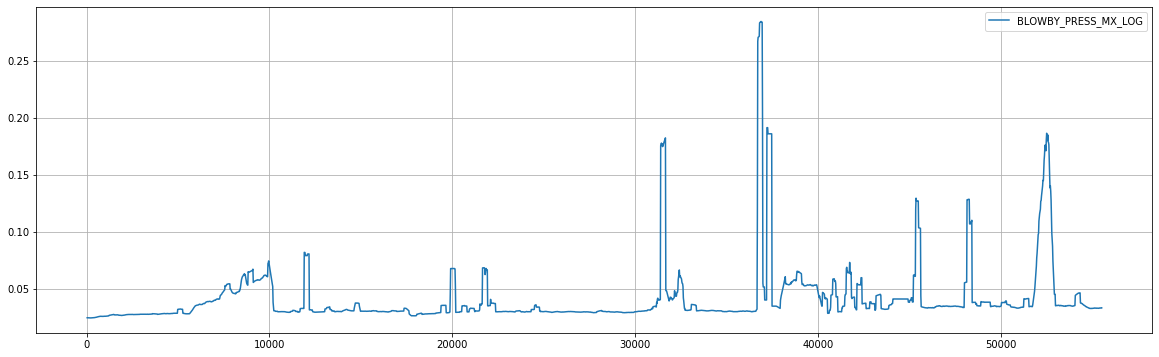

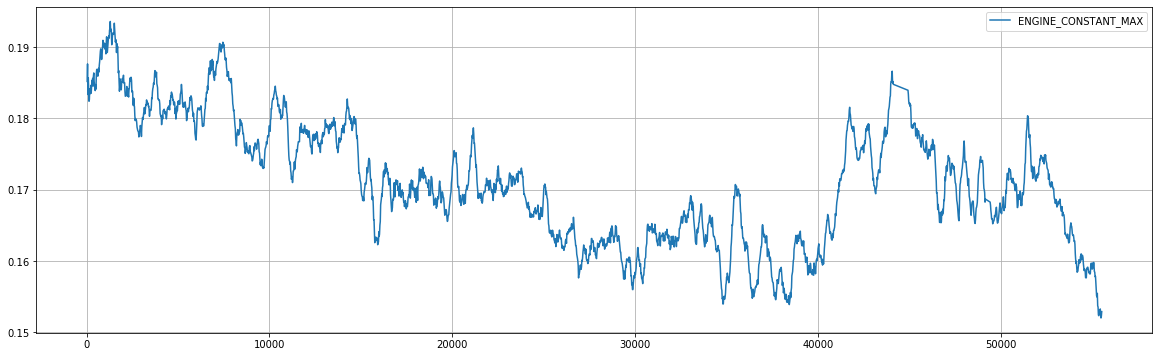

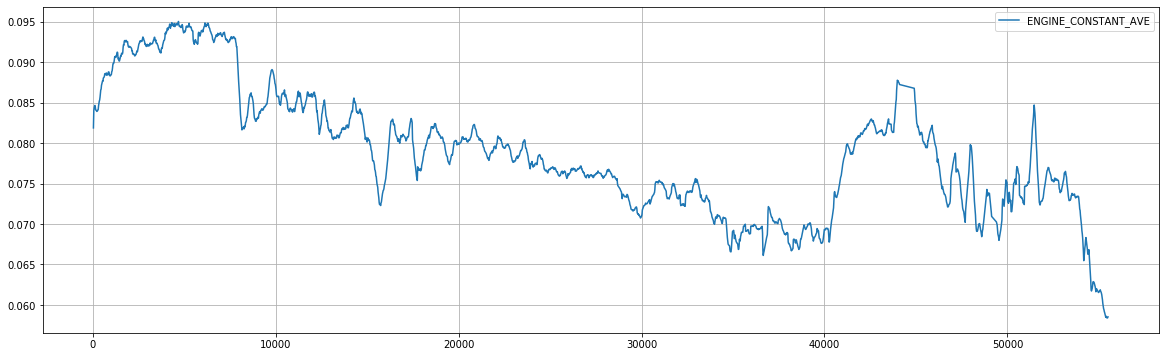

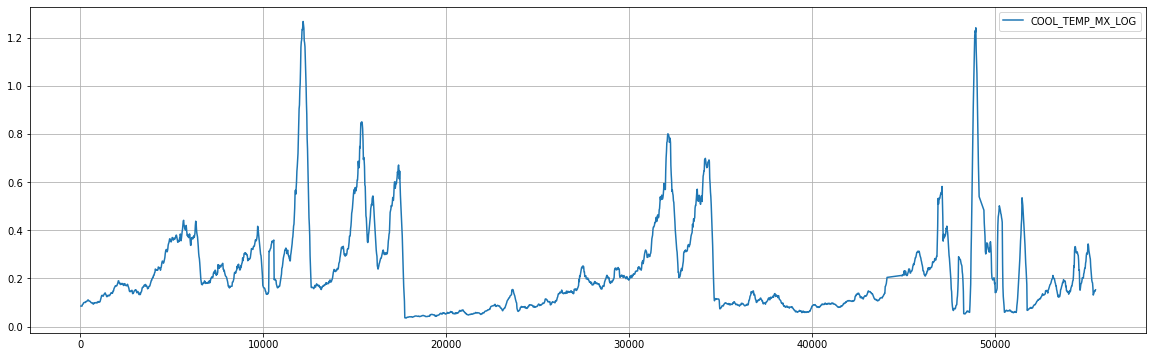

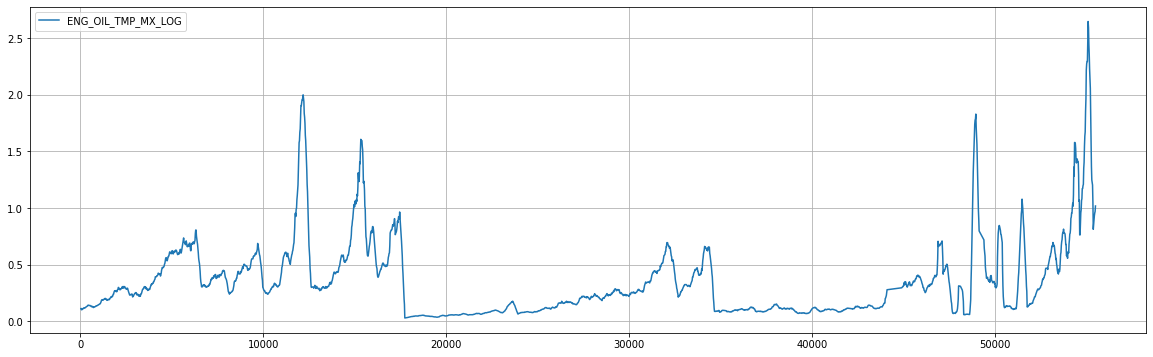

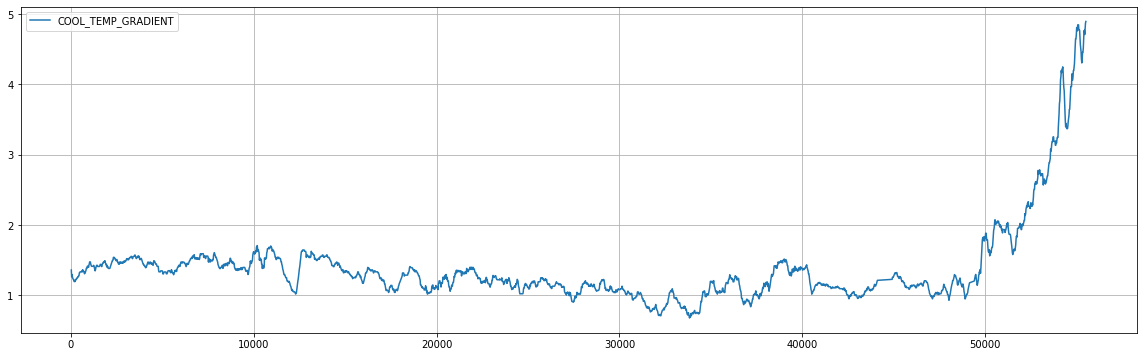

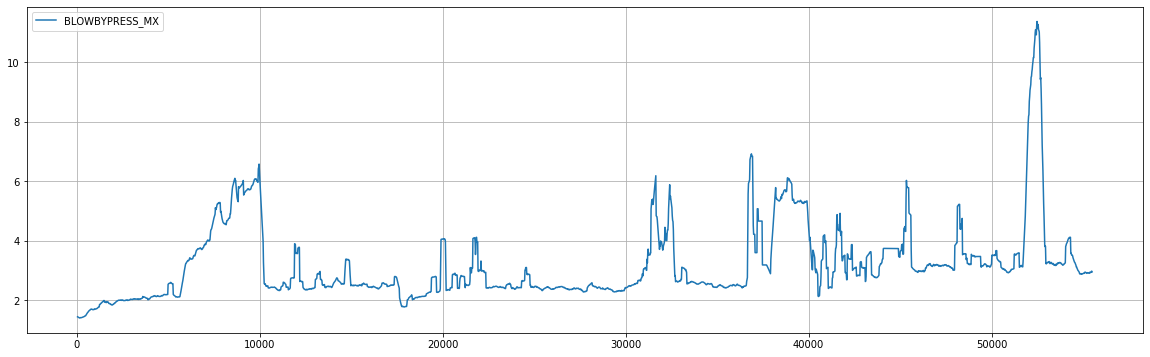

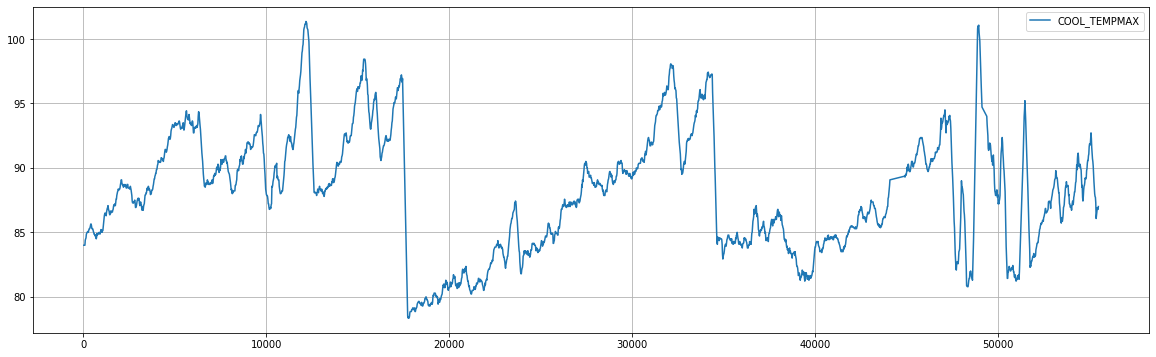

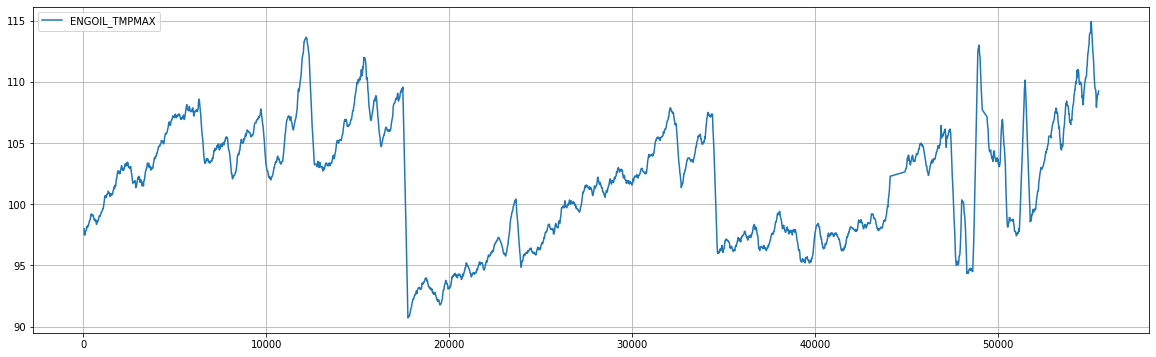

In [48]:
srl_num = '20194'
vhms = vhms_pipe.transform(
    vhms_trend_pc2000_selected[vhms_trend_pc2000_selected['UNIT_SRL_NUM']==srl_num].copy())
pap = pap_pipe.transform(
    pap_oil[pap_oil['SRL_NUM']==srl_num].copy())

scoring_dataset = join_vhms_with_pap(vhms, pap, time_window=30)
scoring_dataset['with_pap'] = scoring_dataset['LAB_NUM'].map(lambda x: True if x is not None and x==x else False)
# scoring_dataset['with_pap'] = False
scoring_dataset = scoring_dataset.sort_values('SMR')

hs_result = hs_scoring_pipe.transform(scoring_dataset)
hs = hs_result[:,0].astype(np.double)

# equipment information
equipment_info = unit_population_latest[
    (unit_population_latest['SRL_NUM']==srl_num) & 
    (unit_population_latest['MODL_NUM']=='PC2000-8')].reset_index().loc[0]
print(equipment_info)
hist = hist_comp_repl[(hist_comp_repl['SRL_NUM']==srl_num) & 
                      (hist_comp_repl['COMPONENT']=="ENGINE ASSY")][
    ["REP_NUM", "STATUS", "BEG_HM", "END_HM", "LIFETIME_HOUR"]]
print(hist)

# plot
plt.figure(figsize=(20,6))
smoothing_window = 8
scoring_dataset['health_score'] = make_smooth(hs,window_size=smoothing_window)

without_pap_index = scoring_dataset[scoring_dataset['with_pap']==False].index
plt.plot(scoring_dataset['SMR'],  scoring_dataset['health_score'], "-",
         label="", color="orange")
plt.plot(scoring_dataset.loc[without_pap_index, 'SMR'], 
         scoring_dataset.loc[without_pap_index, 'health_score'], '^', 
         label='without PAP', color='red', alpha=0.5)
plt.grid()
plt.legend()
plt.show()

param = ["BLOWBY_PRESS_MX_LOG", "ENGINE_CONSTANT_MAX", "ENGINE_CONSTANT_AVE",
         "COOL_TEMP_MX_LOG", "ENG_OIL_TMP_MX_LOG", "COOL_TEMP_GRADIENT", 
         "BLOWBYPRESS_MX", "COOL_TEMPMAX", "ENGOIL_TMPMAX"]
for p in param:
    plt.figure(figsize=(20,6))
    y = scoring_dataset[p]
    plt.plot(scoring_dataset['SMR'], make_smooth((y), window_size=smoothing_window), label=p)
    plt.grid()
    plt.legend()
    plt.show()

# Prepare Data For Scoring Script

In [51]:
sample = vhms_trend_pc2000[vhms_trend_pc2000['UNIT_SRL_NUM']=='20194'].reset_index(drop=True)
print(len(sample))

2716


In [50]:
# sample input data 2
# sample = vhms_trend_hd785_selected.loc[100:103, ['UNIT_MODL','UNIT_SRL_NUM', 'SMR', 'TIMESTAMP']+primary_features]
# sample = vhms_trend_hd785_selected[vhms_trend_hd785_selected['UNIT_SRL_NUM']=='30025'].reset_index(drop=True)
pap_data = []
for idx in sample.index:
    vhms = sample.loc[idx]
    pap = get_match_pap(pap_oil, 
                        srl_num=vhms.get('UNIT_SRL_NUM'),
                        date=str(vhms.get('TIMESTAMP')),
                        component='ENGINE')[['LAB_NUM','MODL_NUM', 'SRL_NUM', 'SAMPL_DT','HRS_KM_TOT', 'HRS_KM_OC', 'COMPONENT']+pap_features]
    pap_data.append(pap)
pap_data = pd.concat(pap_data).drop_duplicates().reset_index(drop=True)

vhms = from_pandas_to_json(sample)
pap = from_pandas_to_json(pap_data)
data = {"unit_model": "PC2000-8", "component": "engine", "vhms": vhms, "pap":pap}
write_data_to_json(data, "sample_data_input_pc2000_allrecords.json")

# Generate Health Score Dataset for RUL Regression

health_score_collection = []
for i, srl_num in enumerate(srl_num_passed):
    vhms_kpp = vhms_trend_pc2000[vhms_trend_pc2000['UNIT_SRL_NUM']==srl_num]
    if len(vhms_kpp) > 100:
        vhms = vhms_pipe.transform(vhms_kpp.copy())
        vhms['UNIT_MODL'] = 'PC2000-8'

        pap = pap_pipe.transform(
            pap_oil[pap_oil['SRL_NUM']==srl_num].copy())

        scoring_dataset = join_vhms_with_pap(vhms, pap, time_window=30)
        scoring_dataset['with_pap'] = scoring_dataset['LAB_NUM'].map(lambda x: True if x is not None and x==x else False)

        hs_result = hs_scoring_pipe.transform(scoring_dataset)
        hs = hs_result[:,0].astype(np.double)

        smoothing_window = 5
        smoothing_window_param = 3
        scoring_dataset['health_score'] = make_smooth(hs,window_size=smoothing_window)
        health_score_collection.append(scoring_dataset)
        
        print("Finish {0} of {1}, serial number: {2} is saved".format(i+1, len(srl_num_passed), srl_num))
    else:
        print("Finish {0} of {1}, serial number: {2} si discarded".format(i+1, len(srl_num_passed), srl_num))

health_score_dataset = pd.concat(health_score_collection)
fn = 'pc2000_engine_healthscore_dataset.csv'
health_score_dataset.to_csv(fn, index=False)
print("Saved {0} records health score dataset to {1}".format(len(health_score_dataset), fn))